<a href="https://colab.research.google.com/github/durml91/MMath-Project/blob/duo-branch/Image_Diffusion_(working)/DiT%20Diffusion/DiT-V2-CIFAR_hq_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DiT implementation**

### Imports and Installs

Need to install new version of Jax for package compatibility

In [1]:
!pip install jaxlib==0.4.2+cuda11.cudnn82 -f  https://storage.googleapis.com/jax-releases/jax_cuda_releases.html # [cuda]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.4/164.4 MB 5.5 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.4+cuda11.cudnn82
    Uninstalling jaxlib-0.4.4+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.4.4+cuda11.cudnn82


Install packages

In [ ]:
!pip install diffrax
!pip install equinox
!pip install einops
!pip install optax

Imports

In [3]:
import array
import functools as ft
import gzip
import os
import struct
import urllib.request

import diffrax as dfx  # https://github.com/patrick-kidger/diffrax
import einops  # https://github.com/arogozhnikov/einops
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

import equinox as eqx

**Generate rng key**

In [4]:
key = jr.PRNGKey(2023)

Setup for saving model parameters - only run once!

In [6]:
import shutil
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Data loader and data shuffler

In [7]:
def mnist():
    filename = "train-images-idx3-ubyte.gz"
    url_dir = "https://storage.googleapis.com/cvdf-datasets/mnist"
    target_dir = os.getcwd() + "/data/mnist"
    url = f"{url_dir}/{filename}"
    target = f"{target_dir}/{filename}"

    if not os.path.exists(target):
        os.makedirs(target_dir, exist_ok=True)
        urllib.request.urlretrieve(url, target)
        print(f"Downloaded {url} to {target}")

    with gzip.open(target, "rb") as fh:
        _, batch, rows, cols = struct.unpack(">IIII", fh.read(16))
        shape = (batch, 1, rows, cols)
        return jnp.array(array.array("B", fh.read()), dtype=jnp.uint8).reshape(shape)

def cifar():
  from tensorflow.keras.datasets import cifar10
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()

  set1 = jnp.array(x_train)
  set2 = jnp.array(x_test)

  data = jnp.concatenate((set1, set2))

  data_reag = einops.rearrange(data, "n h w c -> n c h w")
  return data_reag


def dataloader(data, batch_size, *, key):
    dataset_size = data.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield data[batch_perm]
            start = end
            end = start + batch_size

### DiT Model

**Utility functions**

In [8]:
@eqx.filter_jit
def modulate(x, shift, scale):
    scale = jnp.expand_dims(scale, axis=0) 
    shift = jnp.expand_dims(shift, axis=0)  
    c = (1 + scale) + shift
    return x * c

In [9]:
@eqx.filter_jit
def get_2d_sincos_pos_embed(n_embd, grid_size):

    grid_h = jnp.arange(grid_size, dtype=float)
    grid_w = jnp.arange(grid_size, dtype=float)
    grid = jnp.meshgrid(grid_w, grid_h)
    grid = jnp.stack(grid, axis=0)

    #grid = einops.rearrange(grid, " 2 d f -> 2 1 d f")
    grid = jnp.reshape(grid, (2, 1, grid_size, grid_size))
    pos_embed = get_2d_sincos_pos_embed_from_grid(n_embd, grid)
    return pos_embed


##################################################################################

@eqx.filter_jit
def get_2d_sincos_pos_embed_from_grid(n_embd, grid):
    assert n_embd % 2 == 0


    emb_h = get_1d_sincos_pos_embed_from_grid(n_embd // 2, grid[0]) # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(n_embd // 2, grid[1]) # (H*W, D/2)

    emb = jnp.concatenate([emb_h, emb_w], axis=1)  #(H*W, D)
    return emb


##################################################################################

@eqx.filter_jit
def get_1d_sincos_pos_embed_from_grid(n_embd, pos):
    assert n_embd % 2 == 0
    omega = jnp.arange(n_embd // 2, dtype=float)
    omega /= n_embd / 2
    omega = 1. / 10000*omega #(D/2)

    pos = jnp.array(pos)
    #print(pos.shape)
    #pos = einops.rearrange(pos, "a -> a 0")
    out = jnp.outer(pos, omega)

    emb_sin = jnp.sin(out)
    emb_cos = jnp.cos(out)

    emb = jnp.concatenate([emb_sin, emb_cos], axis=1)
    return emb

**NN modules**

In [10]:
#############################################
##############                ###############
##############    DiT model   ###############
##############                ###############
#############################################

"""Diffusion models meet Transformers!"""


###########   Time embedding    #############



###### Define silu activation ######

from typing import Callable

class Lambda1(eqx.Module):
    fn: Callable
    
    def __call__(self, x, *, key=None):
        return self.fn(x)

###### Time embedding ######

class TimeStepEmbedder(eqx.Module):
    mlp: eqx.nn.Sequential
    frequency_embedding_size: int
    
    def __init__(
        self,
        hidden_size,
        frequency_embedding_size,   #set as 256
        key
    ):
        l1key, l2key = jr.split(key, 2)
        self.mlp = eqx.nn.Sequential([
            eqx.nn.Linear(frequency_embedding_size, hidden_size, key=l1key),
            Lambda1(jax.nn.silu),
            eqx.nn.Linear(hidden_size, hidden_size, key=l2key)
        ])
        self.frequency_embedding_size = frequency_embedding_size

    def __call__(self, t, max_period=10000):
        dim = self.frequency_embedding_size
        half = dim // 2
        freqs = jnp.exp(
            -jnp.log(max_period) * jnp.arange(0, half, dtype=float) / half
        )
        args = t[:, None].astype(float) * freqs[None]
        embedding = jnp.concatenate([jnp.cos(args), jnp.sin(args)], axis=-1)
        if dim % 2:
            embedding = jnp.concatenate([embedding, jnp.zeros_like(embedding[:, :1])], axis=-1)
        t_freq = embedding
        t_emb = jax.vmap(self.mlp)(t_freq)
        return t_emb




##########   Multi-Head Attention   #########


class MultiAtt(eqx.Module):
    c_attn: eqx.nn.Linear
    c_proj: eqx.nn.Linear
    n_head: int
    mha: eqx.nn.MultiheadAttention

    def __init__(self, n_embd, n_head, key):
        assert n_embd % n_head ==0
        atkey, prkey, mhakey = jr.split(key, 3)
        self.c_attn = eqx.nn.Linear(n_embd, 3 * n_embd, key=atkey)
        self.c_proj = eqx.nn.Linear(n_embd, n_embd, key=prkey)
        self.n_head = n_head
        self.mha = eqx.nn.MultiheadAttention(n_head, n_embd, key=mhakey)

    def __call__(self, x, mask=None):
        B, T, C = x.shape
        qkv = jax.vmap(jax.vmap(self.c_attn))(x)
        q, k, v = jnp.array_split(qkv, 3, axis=-1)
        values = jax.vmap(self.mha)(q, k, v)
        out = jax.vmap(jax.vmap(self.c_proj))(values)
        return out


##############    DiT Block     ##############


class DitBlock(eqx.Module):
    norm1: eqx.nn.LayerNorm
    norm2: eqx.nn.LayerNorm
    attn: eqx.Module
    Mlp: eqx.nn.MLP
    adaLN_modulation: eqx.nn.Sequential

    def __init__(
        self,
        hidden_size,
        n_head,
        mlp_ratio,   # = 4.0
        key,
    ):
        mkey, adakey = jr.split(key, 2)
        self.norm1 = eqx.nn.LayerNorm(hidden_size, eps = 1e-06, elementwise_affine=False)
        self.attn = MultiAtt(hidden_size, n_head=n_head, key=key)
        self.norm2 = eqx.nn.LayerNorm(hidden_size, eps = 1e-06, elementwise_affine=False)
        mlp_hidden_size = int(hidden_size * mlp_ratio)
        self.Mlp = eqx.nn.MLP(hidden_size, hidden_size, mlp_hidden_size, 1, key=mkey)
        self.adaLN_modulation = eqx.nn.Sequential([
            Lambda1(jax.nn.silu),
            eqx.nn.Linear(hidden_size, 6 * hidden_size, key=adakey)
        ])

    def __call__(self, x, c):
        temp = jax.vmap(self.adaLN_modulation)(c)
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = jnp.array_split(temp, 6, axis=1)
        gate_msa = jnp.expand_dims(gate_msa, axis=0)
        a = jax.vmap(self.norm1)(x)
        tem = modulate(a, shift_msa, scale_msa)
        x = x + gate_msa * self.attn(tem)
        gate_mlp = jnp.expand_dims(gate_mlp, axis=0)
        b = jax.vmap(self.norm2)(x)
        tems = modulate(self.norm2(x), shift_mlp, scale_mlp)     
        x = x + gate_mlp * jax.vmap(jax.vmap(self.Mlp))(tems)
        return x




#################   Final Layer   ################



class FinalLayer(eqx.Module):
    norm_final: eqx.nn.LayerNorm
    linear: eqx.nn.Linear
    adaLN_modulation: eqx.nn.Linear
    
    def __init__(
        self,
        hidden_size,
        patch_size,
        out_channels,
        key
    ):
        lkey, adakey = jr.split(key, 2)
        self.norm_final = eqx.nn.LayerNorm(hidden_size, eps=1e-6, elementwise_affine=False)
        self.linear = eqx.nn.Linear(hidden_size, patch_size * patch_size * out_channels, key=lkey)
        self.adaLN_modulation = eqx.nn.Linear(hidden_size, 2 * hidden_size, key=adakey)

    def __call__(self, x, c):
        c = jax.nn.silu(c)
        temp = jax.vmap(self.adaLN_modulation)(c)
        shift, scale = jnp.array_split(temp, 2, axis=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = jax.vmap(jax.vmap(self.linear))(x)
        return x


###########   Patch embedding   ##############

class PatchEmbed(eqx.Module):
    num_patches:int
    proj: eqx.nn.Conv2d
    patch_size: int

    def __init__(
        self,
        img_size,
        patch_size,
        in_chans,
        n_embd,
        key
    ):
        patkey, _ = jr.split(key,2)
        self.patch_size = patch_size
        dg = img_size // self.patch_size
        self.num_patches = dg ** 2
        self.proj = eqx.nn.Conv2d(in_chans, n_embd, self.patch_size, self.patch_size, key=patkey)

    def __call__(self, x):
        B, C, H, W = x.shape
        x = jnp.array(x, dtype=float)
        x = jax.vmap(self.proj)(x)
        x = einops.rearrange(x, "B C H W -> B (H W) C")
        return x



###########   Parameter module    ##########

class Params(eqx.Module):
    param: jnp.ndarray

    def __init__(self, num_patches, hidden_size):
        self.param = jnp.zeros((1, num_patches, hidden_size), dtype = float)

    def __call__(self):
        return self.param


##########    DiT   ##########


class DiT(eqx.Module):
    in_channels: int
    out_channels: int
    patch_size: int
    n_head: int

    x_embedder: eqx.Module
    t_embedder: eqx.Module
    pos_embed: eqx.Module
    blocks: list
    final_layer: eqx.Module

    def __init__(
        self,
        input_size=32,
        patch_size=4,
        in_channels=3,
        hidden_size=512,
        depth=10,
        n_head=10,
        mlp_ratio=4.0,  #fixed
        frequency_embedding_size=256,   #fixed
        *,
        key=key,
        
    ):
        xkey, tkey, flkey, *dbkeys = jr.split(key, 3 + depth)
        self.in_channels = in_channels
        self.out_channels = in_channels
        self.patch_size = patch_size
        self.n_head = n_head
        self.x_embedder = PatchEmbed(input_size, patch_size, in_channels, hidden_size, key=xkey)
        self.t_embedder = TimeStepEmbedder(hidden_size, frequency_embedding_size, key=tkey)
        num_patches = self.x_embedder.num_patches
        self.pos_embed = Params(num_patches, hidden_size)
        self.blocks = [
            DitBlock(
                hidden_size, n_head, mlp_ratio, key = key
            )
            for dbkey in dbkeys                                   #_ in range(depth)           #*bkeys = jr.split(key, num_blocks)
        ]
        self.final_layer = FinalLayer(hidden_size, patch_size, self.out_channels, key=flkey)

        pos_embed = get_2d_sincos_pos_embed(self.pos_embed().shape[-1], int(self.x_embedder.num_patches ** 0.5))
        pos_embed = jnp.array(pos_embed, dtype=float)
        self.pos_embed = jnp.expand_dims(pos_embed, axis=0)
    
    def unpatchify(self, x):
        """
        x: (N, T, patch_size ** 2 * C)
        imgs: (N, H, W, C)
        """
        c = self.out_channels      
        p = self.x_embedder.patch_size 
        h = w = int(x.shape[1] ** 0.5)    
        x = jnp.reshape(x, (x.shape[0], h, w, p, p, c))
        x = einops.rearrange(x, "n h w p q c->n c h p w q")
        imgs = jnp.reshape(x, (x.shape[0], c, h * p, h * p))
        return imgs
    
    def __call__(self, x, t):
        #pos_embed = get_2d_sincos_pos_embed(self.pos_embed().shape[-1], int(self.x_embedder.num_patches ** 0.5))
        
        
        """
        x: (N, C, H, W)
        t: (N, )
        """
        
        t = jnp.array([t], dtype=int)
        x = self.x_embedder(x) + self.pos_embed  # (N, T, D), where T = H * W / patch_size ** 2
        t = self.t_embedder(t)   # (N, D)
        for block in self.blocks:
            x = block(x,t)    # (N, T, D)
        x = self.final_layer(x, t)     # (N, T, patch_size ** 2 * out_channels) - N is the batch_size, T is the number of patches, 
        x = self.unpatchify(x)        # (N, out_channels, H, W)
        x = jnp.squeeze(x, axis=0)
        return x

### Debugging functions

In [ ]:
model = DiT()

Test

In [ ]:
data = mnist()

Downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz to /content/data/mnist/train-images-idx3-ubyte.gz


In [ ]:
data.shape

(60000, 1, 28, 28)

In [ ]:
eg = data[0]
eg = eg[None,:,:,:]

In [ ]:
eg.shape

(1, 1, 28, 28)

In [ ]:
t = 2

In [ ]:
model(eg, t).shape

(1, 28, 28)

### Loss functions

In [11]:
def single_loss_fn(model, weight, int_beta, data, t, key):
    mean = data * jnp.exp(-0.5 * int_beta(t))
    var = jnp.maximum(1 - jnp.exp(-int_beta(t)), 1e-5)
    std = jnp.sqrt(var)
    noise = jr.normal(key, data.shape)
    y = mean + std * noise
    y = jnp.expand_dims(y, axis=0)
    pred = model(y,t)
    return weight(t) * jnp.mean((pred + noise / std) ** 2)


def batch_loss_fn(model, weight, int_beta, data, t1, key):
    batch_size = data.shape[0]
    tkey, losskey = jr.split(key)
    losskey = jr.split(losskey, batch_size)
    # Low-discrepancy sampling over t to reduce variance
    t = jr.uniform(tkey, (batch_size,), minval=0, maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)
    loss_fn = ft.partial(single_loss_fn, model, weight, int_beta)
    loss_fn = jax.vmap(loss_fn)
    return jnp.mean(loss_fn(data, t, losskey))

### Update function

In [12]:
@eqx.filter_jit
def make_step(model, weight, int_beta, data, t1, key, opt_state, opt_update):
    loss_fn = eqx.filter_value_and_grad(batch_loss_fn)
    loss, grads = loss_fn(model, weight, int_beta, data, t1, key)
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    key = jr.split(key, 1)[0]
    return loss, model, key, opt_state

### Sampler

In [13]:
@eqx.filter_jit
def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
    def drift(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        y = jnp.expand_dims(y, axis=0)
        c = -0.5 * beta * (y + model(y,t))
        #print(c.shape)
        c = jnp.squeeze(c, axis=0)
        return c

    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0
    y1 = jr.normal(key, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1)
    return sol.ys[0]

### Training Loop

##### Future main training loop

In [ ]:
def main(
    # Model hyperparameters
    input_size=28,
    patch_size=4,
    in_channels=1,
    hidden_size=384,
    depth=4,
    n_head=6,
    mlp_ratio=4.0,
    frequency_embedding_size=256,
    t1=10.0,
    # Optimisation hyperparameters
    num_steps=1_000_000,
    lr=3e-4,
    batch_size=256,
    print_every=5_000,
    # Sampling hyperparameters
    dt0=0.1,
    sample_size=10,
    # Seed
    seed=2023,
):
    key = jr.PRNGKey(seed)
    model_key, train_key, loader_key, sample_key = jr.split(key, 4)
    data = mnist()
    data_mean = jnp.mean(data)
    data_std = jnp.std(data)
    data_max = jnp.max(data)
    data_min = jnp.min(data)
    #data_shape = data.shape[1:]
    data = (data - data_mean) / data_std

    model = DiT(
        input_size,
        patch_size,
        in_channels,
        hidden_size,
        depth,
        n_head,
        mlp_ratio,
        frequency_embedding_size,
        key=model_key,
    )
    int_beta = lambda t: t  # Try experimenting with other options here!
    weight = lambda t: 1 - jnp.exp(
        -int_beta(t)
    )  # Just chosen to upweight the region near t=0.

    opt = optax.adabelief(lr)
    # Optax will update the floating-point JAX arrays in the model.
    opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

    total_value = 0
    total_size = 0
    for step, data in zip(
        range(num_steps), dataloader(data, batch_size, key=loader_key)
    ):
        value, model, train_key, opt_state = make_step(
            model, weight, int_beta, data, t1, train_key, opt_state, opt.update
        )
        total_value += value.item()
        total_size += 1
        if (step % print_every) == 0 or step == num_steps - 1:
            print(f"Step={step} Loss={total_value / total_size}")
            total_value = 0
            total_size = 0

    sample_key = jr.split(sample_key, sample_size**2)
    sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
    sample = jax.vmap(sample_fn)(sample_key)
    sample = data_mean + data_std * sample
    sample = jnp.clip(sample, data_min, data_max)
    sample = einops.rearrange(
        sample, "(n1 n2) 1 h w -> (n1 h) (n2 w)", n1=sample_size, n2=sample_size
    )
    plt.imshow(sample, cmap="Greys")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

##### Temporary manual training loop

In [14]:
t1=10.0
# Optimisation hyperparameters
num_steps=200_000
lr=3e-4
batch_size=256
print_every=1_000

In [15]:
data = cifar()
data_mean = jnp.mean(data)
data_std = jnp.std(data)
data_max = jnp.max(data)
data_min = jnp.min(data)
data_shape = data.shape[1:]
data = (data - data_mean) / data_std

170498071/170498071 [==============================] - 13s 0us/step


In [16]:
loader_key, train_key, model_key, sample_key = jr.split(key, 4)

In [17]:
model = DiT(key = model_key)

In [18]:
int_beta = lambda t: t  # Try experimenting with other options here!
weight = lambda t: 1 - jnp.exp(-int_beta(t))  

In [19]:
opt = optax.adabelief(lr)
# Optax will update the floating-point JAX arrays in the model.
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

In [20]:
from pickle import dump, load
lossdict = {}

In [21]:
total_value = 0
total_size = 0
for step, data in zip(range(num_steps), dataloader(data, batch_size, key=loader_key)): 
    value, model, train_key, opt_state = make_step(model, weight, int_beta, data, t1, train_key, opt_state, opt.update)
    total_value += value.item()
    total_size += 1
    if (step % print_every) == 0 or step == num_steps - 1:
        print(f"Step={step} Loss={total_value / total_size}")
        lossdict[step] = (total_value / total_size)
        total_value = 0
        total_size = 0

XlaRuntimeError: ignored

**Save model**

In [ ]:
eqx.tree_serialise_leaves("DiT_cifar_hq.eqx", model)
shutil.copy('/content/DiT_cifar_hq.eqx','/content/gdrive/MyDrive/Colab_Notebooks')

'/content/gdrive/MyDrive/Colab_Notebooks/DiT_cifar.eqx'

**Save losses**

In [ ]:
with open('./DiT_cifar_hq_losses.pkl', 'wb') as file:
    dump(lossdict, file)

import shutil
shutil.copy('./DiT_cifar_hq_losses.pkl','/content/gdrive/MyDrive/Colab_Notebooks')

'/content/gdrive/MyDrive/Colab_Notebooks/DiT_cifar_losses.pkl'

### Sampling

In [ ]:
sample_size = 8
dt0 = 0.025

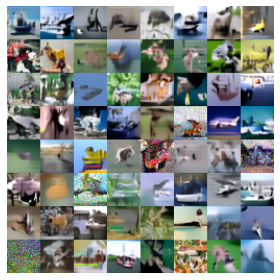

In [ ]:
sample_key = jr.split(sample_key, sample_size**2)
sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(sample_key)
sample = data_mean + data_std * sample
sample = jnp.clip(sample, data_min, data_max)
sample1 = sample[:, 0, :, :]
sample2 = sample[:, 1, :, :]
sample3 = sample[:, 2, :, :]
   
sample1 = einops.rearrange(sample1, "(n1 n2) h w -> (n1 h) (n2 w) ", n1=sample_size, n2=sample_size)
sample2 = einops.rearrange(sample2, "(n1 n2) h w -> (n1 h) (n2 w) ", n1=sample_size, n2=sample_size)
sample3 = einops.rearrange(sample3, "(n1 n2) h w -> (n1 h) (n2 w) ", n1=sample_size, n2=sample_size)

sample1 = sample1[None,:,:]
sample2 = sample2[None,:,:]
sample3 = sample3[None,:,:]
    
newsamp = jnp.concatenate([sample1, sample2, sample3])
sample = einops.rearrange(newsamp, "c h w -> h w c")
sample = jnp.array(sample, dtype=int)
    
    
plt.imshow(sample)
plt.axis("off")
plt.tight_layout()
plt.show()
     

**Loss curve**

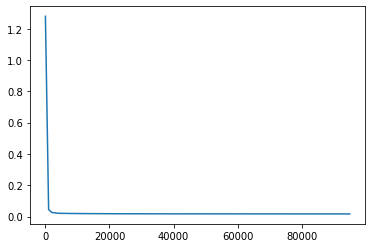

In [ ]:
#test = load(open('./test_to_delete.pkl', 'rb'))

import matplotlib.pylab as plt
myList = lossdict.items()
myList = sorted(myList) 
x, y = zip(*myList) 

plt.plot(x, y)
plt.show()

In [ ]:
a = lossdict.copy()

In [ ]:
del a[0]

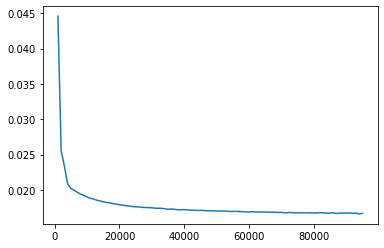

In [ ]:
#test = load(open('./test_to_delete.pkl', 'rb'))

import matplotlib.pylab as plt
myList = a.items()
myList = sorted(myList) 
x, y = zip(*myList) 

plt.plot(x, y)
plt.show()

# Experimentation

**Load Model**

In [ ]:
loaded_model = eqx.tree_deserialise_leaves('/content/gdrive/MyDrive/Colab_Notebooks/DiT_mnist.eqx', model)

###### pkl test - works!

In [ ]:
from pickle import dump, load

In [ ]:
dic = {1000:1.02, 2000:0.9, 3000:0.72, 4000:0.54, 5000:0.34}

In [ ]:
with open('./test_to_delete.pkl', 'wb') as file:
    dump(dic, file)

In [ ]:
import shutil

shutil.copy('./test_to_delete.pkl','/content/gdrive/MyDrive/Colab_Notebooks')

'/content/gdrive/MyDrive/Colab_Notebooks/test_to_delete.pkl'

In [ ]:
 test = load(open('./test_to_delete.pkl', 'rb'))

In [ ]:
test

{1000: 1.02, 2000: 0.9, 3000: 0.72, 4000: 0.54, 5000: 0.34}

In [ ]:
test[6000]=0.054

In [ ]:
test

{1000: 1.02, 2000: 0.9, 3000: 0.72, 4000: 0.54, 5000: 0.34, 6000: 0.054}

In [ ]:
sorted(test.items())

[(1000, 1.02),
 (2000, 0.9),
 (3000, 0.72),
 (4000, 0.54),
 (5000, 0.34),
 (6000, 0.054)]

**Test Graph**

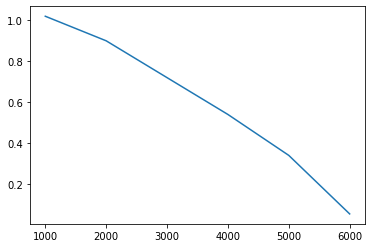

In [ ]:
import matplotlib.pylab as plt
myList = test.items()
myList = sorted(myList) 
x, y = zip(*myList) 

plt.plot(x, y)
plt.show()